### Import Statements

In [1]:
from sklearn.linear_model import Ridge, LinearRegression, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
#from xgboost import XGBRegressor
import seaborn as sns

%matplotlib inline
# plt.style.use("ggplot")
sns.set_style("darkgrid")

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

### Read the Data

In [3]:
data = pd.read_csv("../../clean_data/FinalData_for_Models.csv")

In [4]:
data.rename(columns={'Unnamed: 0':'pickup_time'}, inplace=True)

In [5]:
data.head()

,pickup_time,num_pickups,num_passengers,missing_dt,temp,temp_min,temp_max,humidity,wind_speed,weather_main,weather_description,Passengers,Month,Hour,Day,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights
0,2014-01-01 00:00:00-05:00,107.0,210.0,False,269.27,267.59,270.93,80.0,3.0,clear,sky is clear,108.0,1,0,2,True,0.0,0.0,0.0,0.0,0.0
1,2014-01-01 01:00:00-05:00,34.0,45.0,False,268.90,267.04,270.93,80.0,2.0,clear,sky is clear,0.0,1,1,2,True,0.0,0.0,0.0,0.0,0.0
2,2014-01-01 02:00:00-05:00,34.0,70.0,False,268.48,266.48,270.37,57.0,3.0,clear,sky is clear,0.0,1,2,2,True,0.0,0.0,0.0,0.0,0.0
3,2014-01-01 03:00:00-05:00,12.0,18.0,False,268.33,265.93,270.37,80.0,3.0,clear,sky is clear,0.0,1,3,2,True,0.0,291.0,0.0,0.0,0.0
4,2014-01-01 04:00:00-05:00,25.0,37.0,False,268.10,265.37,270.37,80.0,3.0,clear,sky is clear,0.0,1,4,2,True,0.0,0.0,0.0,0.0,0.0


In [6]:
## ignoring the missing data values in 2016
data = data.loc[data.missing_dt == False, :]
data.drop("missing_dt", axis=1, inplace=True)

In [7]:
data.shape

(26230, 20)

### Creating Dummies for Weather Data

In [8]:
## for weather main
data_wm_dummies = data['weather_main'].str.split(",").str.join("*").str.get_dummies(sep='*')

In [9]:
## for weather description
data_wd_dummies = data['weather_description'].str.split(",").str.join("*").str.get_dummies(sep='*')

In [10]:
data.drop(["weather_main", "weather_description"], axis=1, inplace=True)

In [11]:
data = pd.concat([data, data_wm_dummies], axis=1)

In [12]:
data.shape

(26230, 24)

In [13]:
data.head()

,pickup_time,num_pickups,num_passengers,temp,temp_min,temp_max,humidity,wind_speed,Passengers,Month,Hour,Day,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,210.0,269.27,267.59,270.93,80.0,3.0,108.0,1,0,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,45.0,268.90,267.04,270.93,80.0,2.0,0.0,1,1,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
2,2014-01-01 02:00:00-05:00,34.0,70.0,268.48,266.48,270.37,57.0,3.0,0.0,1,2,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
3,2014-01-01 03:00:00-05:00,12.0,18.0,268.33,265.93,270.37,80.0,3.0,0.0,1,3,2,True,0.0,291.0,0.0,0.0,0.0,1,0,0,0,0,0
4,2014-01-01 04:00:00-05:00,25.0,37.0,268.10,265.37,270.37,80.0,3.0,0.0,1,4,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0


** Remark : We can choose to only include weather main categories or weather description also alongwith <br> TRY BOTH OF THEM FOR MODELS **

### Modifying Boolean Data Columns (Holiday)

In [14]:
data['holiday'] = data.holiday.astype(int)

In [15]:
data.head()

,pickup_time,num_pickups,num_passengers,temp,temp_min,temp_max,humidity,wind_speed,Passengers,Month,Hour,Day,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,210.0,269.27,267.59,270.93,80.0,3.0,108.0,1,0,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,45.0,268.90,267.04,270.93,80.0,2.0,0.0,1,1,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
2,2014-01-01 02:00:00-05:00,34.0,70.0,268.48,266.48,270.37,57.0,3.0,0.0,1,2,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
3,2014-01-01 03:00:00-05:00,12.0,18.0,268.33,265.93,270.37,80.0,3.0,0.0,1,3,2,1,0.0,291.0,0.0,0.0,0.0,1,0,0,0,0,0
4,2014-01-01 04:00:00-05:00,25.0,37.0,268.10,265.37,270.37,80.0,3.0,0.0,1,4,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0


### Time Feature

In [16]:
data.rename(columns={'Hour':'HourOfDay'}, inplace=True)
data.rename(columns={'Day':'DayOfWeek'}, inplace=True)

In [17]:
data.head(2)

,pickup_time,num_pickups,num_passengers,temp,temp_min,temp_max,humidity,wind_speed,Passengers,Month,HourOfDay,DayOfWeek,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,210.0,269.27,267.59,270.93,80.0,3.0,108.0,1,0,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,45.0,268.90,267.04,270.93,80.0,2.0,0.0,1,1,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0


In [18]:
data.shape

(26230, 24)

#### Trying ARIMA

### Drop the Pickup Time and Number of Passengers

In [19]:
data.drop([
        "pickup_time",
        "num_passengers"], axis=1, inplace=True)

## MODELS FOLLOW FROM HERE

#### Dropping cancelled arriving flights and avg_delay_departing as they should have no influence in pickups at LGA

In [20]:
data.drop(['Avg_Delay_Departing', 'Cancelled_Arriving_Flights'], axis=1, inplace=True)

In [21]:
## the labels (num_pickups)
num_pickups = data.num_pickups
data.drop("num_pickups", axis=1, inplace=True)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(data, num_pickups, random_state=0, test_size=0.1)

In [23]:
index = int(data.shape[0]*0.75)
X_train_ts = data.iloc[: index, :]
y_train_ts = num_pickups.iloc[: index]
X_test_ts = data.iloc[index :, :]
y_test_ts = num_pickups.iloc[index :]

In [24]:
tscv = TimeSeriesSplit(n_splits=3)

## Ridge Regression

In [25]:
ridge_pipe = make_pipeline(StandardScaler(), VarianceThreshold(), Ridge())
ridge_params = {'ridge__alpha' : [0.01, 0.1, 1.0, 10.0, 100.0, np.log(14)]}

In [26]:
ridge_grid = GridSearchCV(ridge_pipe, ridge_params, cv=3, scoring='r2')

In [27]:
ridge_grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('variancethreshold', VarianceThreshold(threshold=0.0)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'ridge__alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 2.6390573296152584]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=0)

In [28]:
ridge_grid.best_params_

{'ridge__alpha': 10.0}

In [29]:
ridge_grid.best_score_

0.62856110151227973

## SVR

In [27]:
svr_pipe = make_pipeline(StandardScaler(), VarianceThreshold(), SVR())
svr_params = {'svr__kernel' : ['linear', 'rbf', 'sigmoid'],
             'svr__C' : [1.0, 10.0, 100.0],
             'svr__epsilon' : [0.01, 0.05, 0.1, 0.5]}
svr_grid = GridSearchCV(svr_pipe, svr_params, cv=3, scoring='r2', verbose=2, n_jobs=-1)

In [28]:
svr_grid.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] svr__C=1.0, svr__epsilon=0.01, svr__kernel=linear ...............
[CV] svr__C=1.0, svr__epsilon=0.01, svr__kernel=linear ...............
[CV] svr__C=1.0, svr__epsilon=0.01, svr__kernel=linear ...............
[CV] svr__C=1.0, svr__epsilon=0.01, svr__kernel=rbf ..................
[CV] svr__C=1.0, svr__epsilon=0.01, svr__kernel=rbf ..................
[CV] svr__C=1.0, svr__epsilon=0.01, svr__kernel=rbf ..................
[CV] svr__C=1.0, svr__epsilon=0.01, svr__kernel=sigmoid ..............
[CV] svr__C=1.0, svr__epsilon=0.01, svr__kernel=sigmoid ..............
[CV] svr__C=1.0, svr__epsilon=0.01, svr__kernel=sigmoid ..............
[CV] svr__C=1.0, svr__epsilon=0.05, svr__kernel=linear ...............
[CV] svr__C=1.0, svr__epsilon=0.05, svr__kernel=rbf ..................
[CV] svr__C=1.0, svr__epsilon=0.05, svr__kernel=rbf ..................
[CV] svr__C=1.0, svr__epsilon=0.05, svr__kernel=linear ...............
[CV] svr__C=1.0

[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  5.9min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('variancethreshold', VarianceThreshold(threshold=0.0)), ('svr', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'svr__kernel': ['linear', 'rbf', 'sigmoid'], 'svr__C': [1.0, 10.0, 100.0], 'svr__epsilon': [0.01, 0.05, 0.1, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=2)

In [29]:
svr_grid.best_score_

0.74716491800283125

### Random Forest

In [35]:
rf_pipe = make_pipeline(RandomForestRegressor(n_jobs=-1))
rf_params = {'randomforestregressor__n_estimators' : [10, 50, 100],
             'randomforestregressor__max_features' : [3, 6, 10, 'auto'],
             'randomforestregressor__max_depth' : [5, 10, 
                                                   #None
                                                  ]}
rf_grid = GridSearchCV(rf_pipe, rf_params, cv=3, scoring='r2', verbose=2)

In [36]:
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=3, randomforestregressor__n_estimators=10 
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=3, randomforestregressor__n_estimators=10, total=   0.2s
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=3, randomforestregressor__n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=3, randomforestregressor__n_estimators=10, total=   0.2s
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=3, randomforestregressor__n_estimators=10 
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=3, randomforestregressor__n_estimators=10, total=   0.2s
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=3, randomforestregressor__n_estimators=50 
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=3, randomforestregressor__n_estimators=50, total=   0.4s
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=3, randomforestregressor__n_estimators=50 
[CV]  randomforestregressor__max_depth=5, randomforestregressor__max_features=3, randomforestregressor__n_estimators=50, total=   0.4s
[CV] randomforestregressor__max_depth=5, randomforestregressor__max_features=3, randomforestregresso

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   53.8s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'randomforestregressor__n_estimators': [10, 50, 100], 'randomforestregressor__max_features': [3, 6, 10, 'auto'], 'randomforestregressor__max_depth': [5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=2)

In [37]:
rf_grid.best_score_

0.88647531499292442

In [38]:
rf_grid.best_params_

{'randomforestregressor__max_depth': 10,
 'randomforestregressor__max_features': 'auto',
 'randomforestregressor__n_estimators': 100}

### Gradient Boosting Regressor

In [24]:
gbt_pipe = make_pipeline(GradientBoostingRegressor(random_state=0))
gbt_params = {'gradientboostingregressor__n_estimators' : [50, 100, 200],
              'gradientboostingregressor__max_features' : [3, 6, 'auto'],
#              'gradientboostingregressor__subsample' : [0.2, 0.5, 1.0],
              'gradientboostingregressor__max_depth' : [3, 5, 7],
              'gradientboostingregressor__init' : [None]}
gbt_grid = GridSearchCV(gbt_pipe, gbt_params, cv=tscv, scoring='r2', verbose=3)

In [25]:
gbt_grid.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] gradientboostingregressor__n_estimators=50, gradientboostingregressor__max_depth=3, gradientboostingregressor__init=None, gradientboostingregressor__max_features=3 
[CV]  gradientboostingregressor__n_estimators=50, gradientboostingregressor__max_depth=3, gradientboostingregressor__init=None, gradientboostingregressor__max_features=3, score=0.803306, total=   0.3s
[CV] gradientboostingregressor__n_estimators=50, gradientboostingregressor__max_depth=3, gradientboostingregressor__init=None, gradientboostingregressor__max_features=3 
[CV]  gradientboostingregressor__n_estimators=50, gradientboostingregressor__max_depth=3, gradientboostingregressor__init=None, gradientboostingregressor__max_features=3, score=0.792366, total=   0.2s
[CV] gradientboostingregressor__n_estimators=50, gradientboostingregressor__max_depth=3, gradientboostingregressor__init=None, gradientboostingregressor__max_features=3 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV]  gradientboostingregressor__n_estimators=50, gradientboostingregressor__max_depth=3, gradientboostingregressor__init=None, gradientboostingregressor__max_features=3, score=0.796719, total=   0.2s
[CV] gradientboostingregressor__n_estimators=100, gradientboostingregressor__max_depth=3, gradientboostingregressor__init=None, gradientboostingregressor__max_features=3 
[CV]  gradientboostingregressor__n_estimators=100, gradientboostingregressor__max_depth=3, gradientboostingregressor__init=None, gradientboostingregressor__max_features=3, score=0.833053, total=   0.4s
[CV] gradientboostingregressor__n_estimators=100, gradientboostingregressor__max_depth=3, gradientboostingregressor__init=None, gradientboostingregressor__max_features=3 
[CV]  gradientboostingregressor__n_estimators=100, gradientboostingregressor__max_depth=3, gradientboostingregressor__init=None, gradientboostingregressor__max_features=3, score=0.826306, total=   0.4s
[CV] gradientboostingregressor__n_estimators=100, gra

[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  2.8min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('gradientboostingregressor', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=0, subsample=1.0, verbose=0,
             warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'gradientboostingregressor__n_estimators': [50, 100, 200], 'gradientboostingregressor__max_depth': [3, 5, 7], 'gradientboostingregressor__init': [None], 'gradientboostingregressor__max_features': [3, 6, 'auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=3)

In [27]:
gbt_grid.best_params_

{'gradientboostingregressor__init': None,
 'gradientboostingregressor__max_depth': 7,
 'gradientboostingregressor__max_features': 'auto',
 'gradientboostingregressor__n_estimators': 200}

## XGBoost Regressor

In [39]:
xgb_pipe = make_pipeline(XGBRegressor())
xgb_params = {}
xgb_grid = GridSearchCV(xgb_pipe, xgb_params, cv=3, scoring='r2', verbose=3)

In [40]:
xgb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV]  ................................................................
[CV] ....................... , score=0.8706531169012568, total=   0.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ....................... , score=0.8693851826641639, total=   0.2s
[CV]  ................................................................
[CV] ....................... , score=0.8679147000763284, total=   0.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('xgbregressor', XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))]),
       fit_params=None, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=3)

In [41]:
xgb_grid.best_score_

0.86931766654724962

### Arima Model

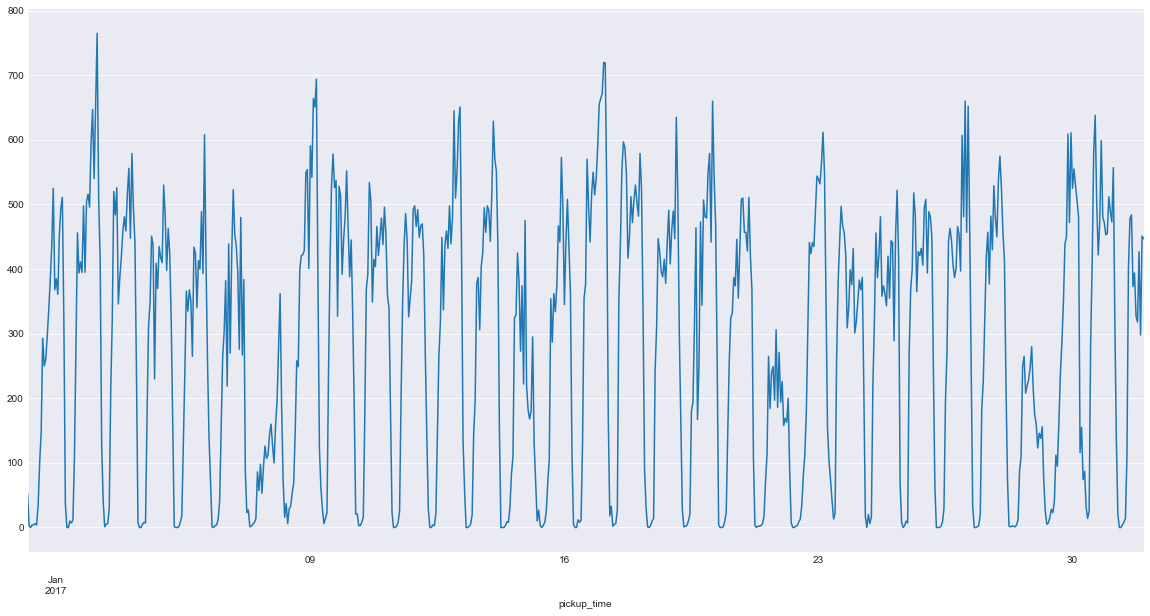

In [42]:
data['2017-01'].num_pickups.plot(figsize=(20,10))

In [33]:
data['2016-08-03']

,num_pickups,temp,temp_min,temp_max,humidity,wind_speed,Passengers,Month,HourOfDay,DayOfWeek,holiday,precip_in,Avg_Delay_Arriving,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
pickup_time,,,,,,,,,,,,,,,,,,,,


In [ ]:
ar_model = arima_model.ARMA(ppm[:500].diff()[1:], order=(12, 0))
res = ar_model.fit()

### MLXTEND

In [25]:
from mlxtend.regressor import StackingCVRegressor, StackingRegressor

In [31]:
X_train_ts_np = X_train_ts.values
X_test_ts_np = X_test_ts.values
y_train_ts_np = y_train_ts.values
y_test_ts_np = y_test_ts.values

In [43]:
ridge = Ridge(alpha=10.0)
#svr = SVR(kernel = 'linear')
#gbd = GradientBoostingRegressor(max_depth=7, max_features='auto', n_estimators=200)
rf = RandomForestRegressor(max_depth=10, max_features='auto', n_estimators=100)
lasso = Lasso(max_iter = 5000)
np.random.seed(42)
stack = StackingCVRegressor(regressors=(ridge, lasso, rf), meta_regressor=lasso, use_features_in_secondary=True)
#stack = StackingRegressor(regressors=(ridge, lasso, rf), meta_regressor=lasso)

In [44]:
tscv = TimeSeriesSplit(n_splits=3)

In [45]:
# for model, label in zip([ridge, lasso, rf, stack], ['Ridge', 'Lasso', 'Random Forest', 'Ensemble']):
#     scores = cross_val_score(model, X_train_ts_np, y_train_ts_np, cv = tscv)
#     print('R^2 score: {} +/- {}, {}'.format(scores.mean(), scores.std(), label))

R^2 score: 0.599194254493 +/- 0.0391107926198, Ridge
R^2 score: 0.600680123856 +/- 0.0359644454468, Lasso
R^2 score: 0.871885659945 +/- 0.0184804775029, Random Forest
R^2 score: 0.871488238947 +/- 0.0193782342536, Ensemble


In [40]:
# stack.fit(X_train_np, y_train_np)

StackingCVRegressor(cv=5,
          meta_regressor=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
          regressors=(Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001), Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=5000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cycl...timators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)),
          shuffle=True, use_features_in_secondary=False)

In [41]:
# stack.score(X_test_np, y_test_np)

0.89114939457153686

In [42]:
# rf = RandomForestRegressor(max_depth=10, max_features='auto', n_estimators=100)
# rf.fit(X_train_np, y_train_np)
# rf.score(X_test_np, y_test_np)

0.89027359861169308

In [61]:
stack_param_grid = {
                    'ridge__alpha' : [x/5.0 for x in range(1, 10)],
                    'lasso__alpha' : [x/20.0 for x in range(1, 10)],
                    'randomforestregressor__n_estimators' : [10, 25, 100],
                    'randomforestregressor__max_depth' : [10, 25, 100, None],
                    'meta-lasso__alpha' : [x/20.0 for x in range(1, 10)],
                    'use_features_in_secondary' : [True, False]
}

In [53]:
# stack_param_grid = {
#                     'ridge__alpha' : [0.1, 10.0],
#                     'lasso__alpha' : [0.1, 1.0],
#                     'lasso__max_iter' : [5000],
#                     'randomforestregressor__n_estimators' : [10, 100],
#                     'randomforestregressor__max_depth' : [10, 25],
#                     'meta-lasso__alpha' : [0.1, 1.0]
# }

In [62]:
grid = GridSearchCV(estimator = stack, param_grid = stack_param_grid, cv = tscv, refit = True, verbose=2)

In [63]:
grid.fit(X_train_ts_np, y_train_ts_np)

Fitting 3 folds for each of 17496 candidates, totalling 52488 fits
[CV] meta-lasso__alpha=0.05, lasso__alpha=0.05, use_features_in_secondary=True, ridge__alpha=0.2, randomforestregressor__max_depth=10, randomforestregressor__n_estimators=10 
[CV]  meta-lasso__alpha=0.05, lasso__alpha=0.05, use_features_in_secondary=True, ridge__alpha=0.2, randomforestregressor__max_depth=10, randomforestregressor__n_estimators=10, total=   4.6s
[CV] meta-lasso__alpha=0.05, lasso__alpha=0.05, use_features_in_secondary=True, ridge__alpha=0.2, randomforestregressor__max_depth=10, randomforestregressor__n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


KeyboardInterrupt: 

In [58]:
grid.score(X_test_ts_np, y_test_ts_np)

0.84100090132213112

In [59]:
grid.best_params_
# lasso__alpha = 1.0
# meta-lasso__alpha = 0.1
# randomforestregressor__max_depth = 10
# randomforestregressor__n_estimators = 100
# ridge__alpha = 10.0

{'lasso__alpha': 1.0,
 'lasso__max_iter': 5000,
 'meta-lasso__alpha': 0.1,
 'randomforestregressor__max_depth': 10,
 'randomforestregressor__n_estimators': 100,
 'ridge__alpha': 10.0}